In [9]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
import skimage.io as io
from skimage.transform import resize
from IPython.display import clear_output

from models import Generator, PatchGAN
from models_utils import *

%matplotlib inline
%load_ext autotime

C:\Users\т\AppData\Local\Programs\Python\Python37\Scripts\kurs\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] Не найден указанный модуль
  warn(f"Failed to load image Python extension: {e}")


time: 0 ns (started: 2022-02-13 14:33:46 +03:00)


<h2>1) Получение данных

Данная функцмя взята из домашнего задания по автоенкодерам

In [14]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=41,dy=41,
                      dimx=256,dimy=256
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos = df['photo_path'].apply(io.imread)\
                                .apply(lambda img: img[dy:-dy,dx:-dx])#\
                                #.apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"], axis=1)
    
    return all_photos, all_attrs

time: 0 ns (started: 2022-02-13 14:33:53 +03:00)


In [15]:
data, attrs = fetch_dataset()
len(data), len(attrs), data.shape, attrs.shape

(13143, 13143, (13143, 168, 168, 3), (13143, 73))

time: 27.3 s (started: 2022-02-13 14:33:53 +03:00)


In [16]:
data = np.swapaxes(data, 1, 3)

time: 0 ns (started: 2022-02-13 14:34:21 +03:00)


Получим даталоадер всех фотографий

In [36]:
data = torch.Tensor(data)
data = data/256
loader_all = DataLoader(data, batch_size=1, num_workers=0, shuffle=True)

time: 0 ns (started: 2022-02-13 16:13:40 +03:00)


Найдем фотографии улыбающихся и неулыбающихся людей соответственно

In [19]:
cnt = 0
smiling = []
for i, row in attrs.iterrows():
    if row['Smiling'] > 1:
        cnt += 1
        smiling.append(i)

time: 1.28 s (started: 2022-02-13 14:34:23 +03:00)


In [20]:
cnt = 0
sad = []
for i, row in attrs.iterrows():
    if row['Smiling'] < -1:
        cnt += 1
        sad.append(i)

time: 891 ms (started: 2022-02-13 14:34:25 +03:00)


In [21]:
smiling_ims = data[smiling]
sad_ims = data[sad]

time: 312 ms (started: 2022-02-13 14:34:25 +03:00)


In [22]:
batch_size = 2
loaderA = DataLoader(smiling_ims, batch_size=batch_size, num_workers=0, shuffle=True, drop_last=True)
loaderB = DataLoader(sad_ims, batch_size=batch_size, num_workers=0, shuffle=True, drop_last=True)

time: 15 ms (started: 2022-02-13 14:34:26 +03:00)


<h2>2) Обучение

In [57]:
#generator, discriminator, opt = init_models(lr = 0.0005, n_res = 6)
generator, discriminator, opt, losses = load_models('smile_5.pt')

time: 547 ms (started: 2022-02-13 17:06:01 +03:00)


In [13]:
criterion_gan = nn.MSELoss()
criterion_cycle = nn.L1Loss()

time: 0 ns (started: 2022-02-12 13:41:03 +03:00)


In [15]:
device = torch.device('cuda')

ones = torch.ones(batch_size, 1, 5, 5, device=device)
zeros = ones = torch.zeros(batch_size, 1, 5, 5, device=device)

def set_req_grad(models, req):
    for model in models:
        for param in model.parameters():
            param.requires_grad = req

def train_discriminator(discr, opt, criterion, real, fake):
    opt.zero_grad()
    output = discr(real)
    loss = criterion(output, ones)/2
    
    output = discr(fake.detach())
    loss += criterion(output, zeros)/2
    loss.backward()
    opt.step()
    return loss.item()

def train_generator(opt, discr, criterion, fake):
    output = discr(fake)
    loss = criterion(output, ones)
    loss.backward(retain_graph=True)
    return loss.item()

def train(epochs, prev_losses = None, lmbda=10):
    if prev_losses:
        losses = prev_losses
    else:
        losses = {
            'discr': {
                'A': [],
                'B': []
            },
            'gen': {
                'A': [],
                'B': [],
                'cycle': []
            }
        }
    for epoch in range(epochs):
        epoch_losses = {
            'discr': {
                'A': [],
                'B': []
            },
            'gen': {
                'A': [],
                'B': [],
                'cycle': []
            }
        }
        iterB = iter(loaderB)
        for A in loaderA:
            B = next(iterB)

            A = A.cuda().float()
            B = B.cuda().float()

            B_fake = generator['B'](A)
            A_fake = generator['A'](B)
            
            set_req_grad([discriminator['A'], discriminator['B']], False)
            
            opt['gen']['A'].zero_grad()
            opt['gen']['B'].zero_grad()
            
            epoch_losses['gen']['A'].append(train_generator(opt['gen']['A'], discriminator['A'], criterion_gan, A_fake))
            epoch_losses['gen']['B'].append(train_generator(opt['gen']['B'], discriminator['B'], criterion_gan, B_fake))
            
            A_repr = generator['A'](B_fake)
            B_repr = generator['B'](A_fake)
            
            cycle_loss = criterion_cycle(A_repr, A)
            cycle_loss += criterion_cycle(B_repr, B)
            cycle_loss *= lmbda
            
            cycle_loss.backward()
            
            epoch_losses['gen']['cycle'].append(cycle_loss.item())
            opt['gen']['A'].step()
            opt['gen']['B'].step()
            
            set_req_grad([discriminator['A'], discriminator['B']], True)
            
            epoch_losses['discr']['A'].append(train_discriminator(discriminator['A'], opt['discr']['A'], criterion_gan, A, A_fake.detach()))
            epoch_losses['discr']['B'].append(train_discriminator(discriminator['B'], opt['discr']['B'], criterion_gan, B, B_fake.detach()))
        for k1 in losses:
            for k2 in losses[k1]:
                losses[k1][k2].append(sum(epoch_losses[k1][k2]) / len(epoch_losses[k1][k2]))
        clear_output(wait=True)
        print('Epoch: '+ str(epoch))
    clear_output(wait=True)
    return losses

time: 1.81 s (started: 2022-02-12 13:41:03 +03:00)


In [16]:
losses = train(20, losses)

time: 8h 1min 12s (started: 2022-02-12 13:41:05 +03:00)


In [61]:
save_models(generator, discriminator, opt, losses, 'smile_5.pt')

time: 797 ms (started: 2022-02-13 17:06:23 +03:00)


Графики лоссов (скачок соответствует уменьшению градиентного шага с 0.0005 до 0.0001)

Лоссы дискриминантов

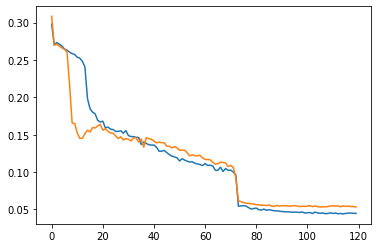

time: 78 ms (started: 2022-02-13 17:06:06 +03:00)


In [59]:
plt.plot(losses['discr']['A'])
plt.plot(losses['discr']['B'])

Лоссы генераторов (зеленым cycle loss)

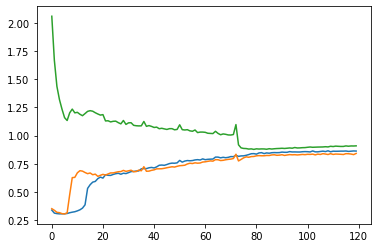

time: 93 ms (started: 2022-02-13 17:06:09 +03:00)


In [60]:
plt.plot(losses['gen']['A'])
plt.plot(losses['gen']['B'])
plt.plot(losses['gen']['cycle'])

<h2>3) Генерация

In [65]:
generator = {}
generator['A'] = torch.load('pretrained/sad2happy.pt')
generator['B'] = torch.load('pretrained/happy2sad.pt')

time: 31 ms (started: 2022-02-13 17:09:58 +03:00)


В качестве тестовых возьмём произвольные изображения людей из датасета (изображения из обучающих выборок тоже могут встретиться, но маловероятно)

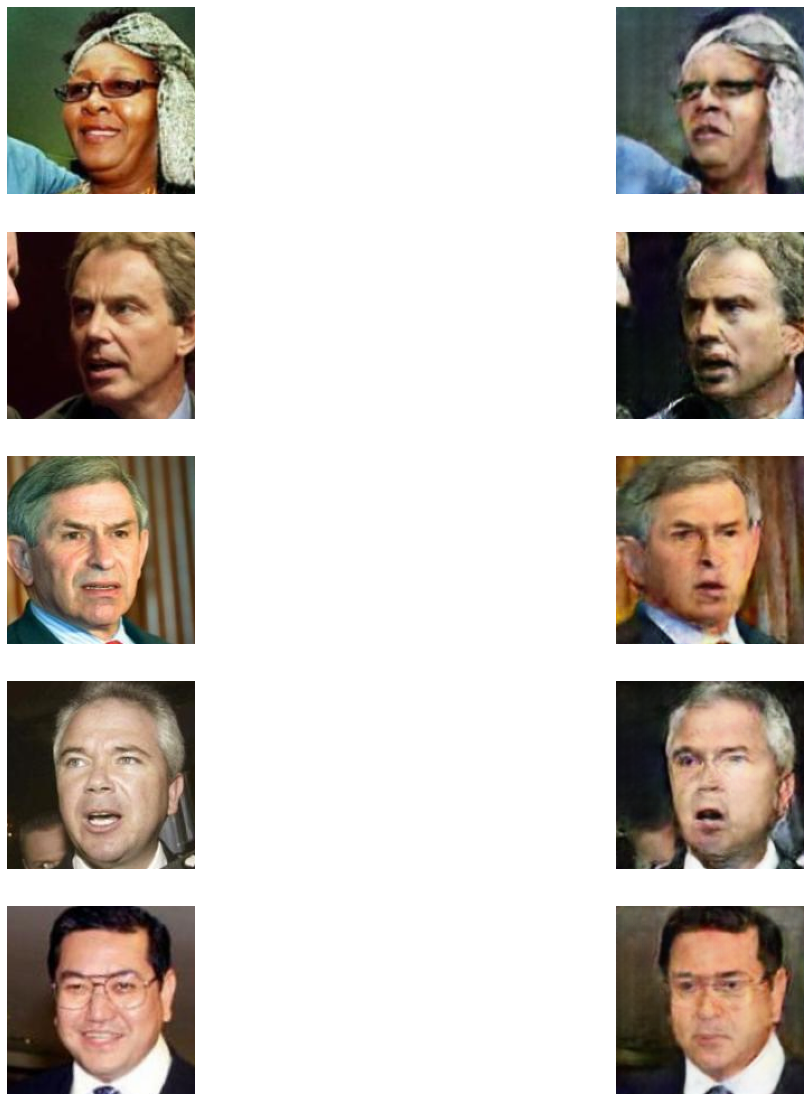

time: 1.91 s (started: 2022-02-13 17:09:59 +03:00)


In [66]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20))

for ax in axs:
    x = next(iter(loader_all))[0, None]
    y = generator['B'].cpu()(x.float())[0].detach()
    ax[0].imshow(x[0].swapaxes(0, 2))
    ax[1].imshow(y.swapaxes(0, 2))
    for axx in ax:
        axx.axis('Off')

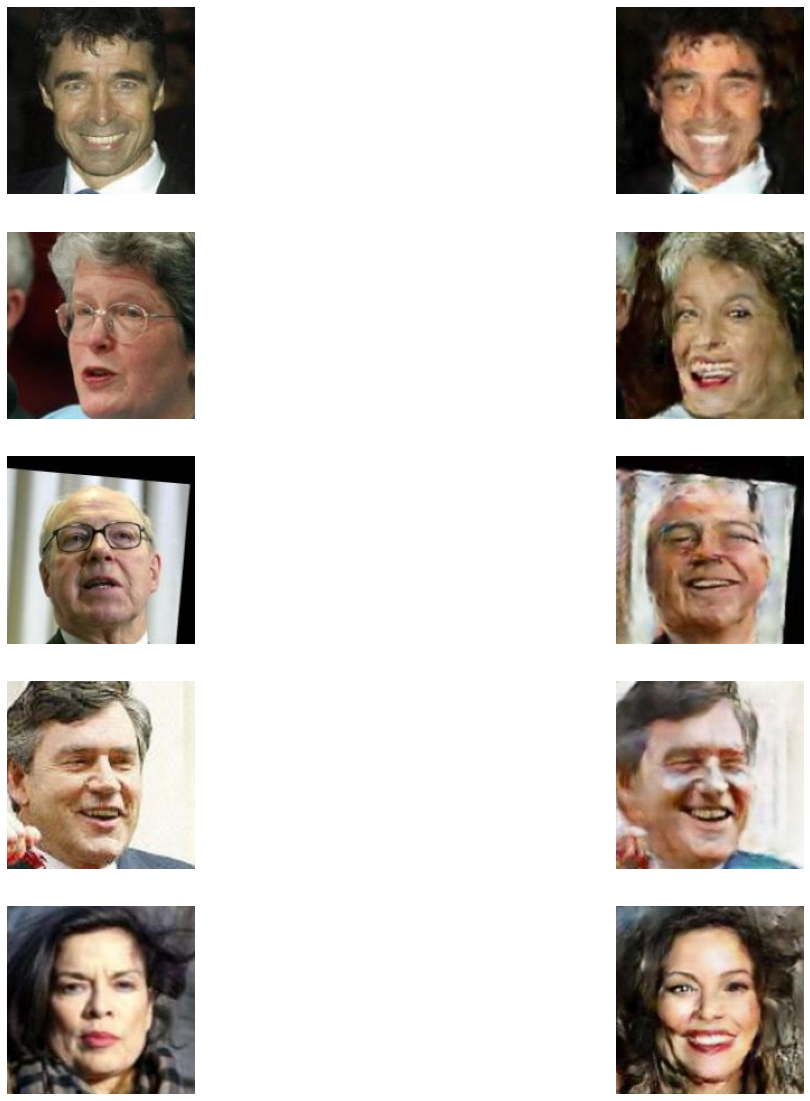

time: 2.06 s (started: 2022-02-13 17:10:01 +03:00)


In [67]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20))

for ax in axs:
    x = next(iter(loader_all))[0, None]
    y = generator['A'].cpu()(x.float())[0].detach()
    ax[0].imshow(x[0].swapaxes(0, 2))
    ax[1].imshow(y.swapaxes(0, 2))
    for axx in ax:
        axx.axis('Off')

Воздействие предполагаемого преобразования на изображение заметно, однако вместе с ним фотографии сильно искажаются и теряют в качестве. Возможно для того, чтобы это избежать стоит поэкспериментировать с гиперпараметрами или больше эпох обучать модель